# Recording Machine

## 4.1 Data Understanding

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime, timedelta

# show the plots
%matplotlib inline
# show all columns
pd.set_option('display.max_columns', None)
# set the backgraound
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":20,"axes.labelsize":18,
                             "xtick.labelsize":15,"ytick.labelsize":15}) 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, TimeSeriesSplit, RepeatedKFold
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

/Users/ConradKang/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def show_results(gap, win):

    total = pd.read_csv('alldata.csv', parse_dates=['time'], index_col='time')
    
    count = total[['ua_count','nike_count']].resample(gap).sum()
    price = total[['ua_price','nike_price']].resample(gap).last()
    stkv = total[['ua_stkv','nike_stkv']].resample(gap).sum()
    tweet = total[['ua_tweet','nike_tweet']].resample(gap).mean()
    twtcount = total[['ua_twtcount','nike_twtcount']].resample(gap).sum()
    total = pd.concat([count, price, stkv, tweet, twtcount], axis = 1)
    
    total['count_ratio'] = total.ua_count / total.nike_count
    total['price_ratio'] = total.ua_price / total.nike_price
    total['tweet_diff'] = total.ua_tweet - total.nike_tweet
    total['stkv_ratio'] = total.ua_stkv / total.nike_stkv
    total['twtcount_ratio'] = total.ua_twtcount / total.nike_twtcount
    
    total = total.rolling(min_periods=1, window=win, center=False).mean() # rolling analysis
    
    # create labels for classification (results for tomorrow)
    value_ua = total.ua_price.shift(-1) - total.ua_price
    value_nike = total.nike_price.shift(-1) - total.nike_price
    value_ratio = total.price_ratio.shift(-1) - total.price_ratio
    
    value_ua = np.where(value_ua>=0, 1, 0)
    value_nike = np.where(value_nike>=0, 1, 0)
    value_ratio = np.where(value_ratio>=0, 1, 0)
    
    total = total.rename(columns={
        'ua_count':'geo_ua_count',
        'nike_count':'geo_nike_count',
        'count_ratio':'geo_count_ratio'
    })
    
    # add rate of returns
    return_ua = total.ua_price/total.ua_price.shift(1) - 1
    return_nike = total.nike_price/total.nike_price.shift(1) - 1
    return_diff = return_ua - return_nike
    
    # add labels and rate of returns to the dataframe
    total['return_ua'] = return_ua
    total['return_nike'] = return_nike
    total['return_diff'] = return_diff
    total['value_ua'] = value_ua
    total['value_nike'] = value_nike
    total['value_ratio'] = value_ratio
    
    total[['ua_tweet','nike_tweet','tweet_diff']] = total[['ua_tweet','nike_tweet','tweet_diff']].fillna(method = 'ffill')
    
    def outlier_eliminate(df):
        s_mean = df.replace([np.inf, -np.inf], np.nan).dropna().mean(axis = 0)
        s_std = df.replace([np.inf, -np.inf], np.nan).dropna().std(axis = 0)
        Q1 = s_mean - 3 * s_std
        Q2 = s_mean + 3 * s_std
        return df[~((df < Q1) | (df > Q2)).any(axis = 1)]
    
    total = outlier_eliminate(total)
    
    total.dropna(inplace = True)
    
    X = total.drop(total.columns[[18,19,20]], axis=1) # drop the target
    y = total.value_ratio.astype('category')
    
    out_feature = int(0.5 * X.shape[1])
    
    threshold = 0.8 # frequently used threshold
    vt = VarianceThreshold().fit(X)
    
    feat_var_threshold = X.columns[vt.variances_ > threshold * (1 - threshold)]
    
    modelr = RandomForestClassifier(random_state = 42)
    modelr.fit(X, y)
    
    feature_impr = pd.DataFrame(modelr.feature_importances_, index=X.columns, columns=["importance"])
    feat_imp_rf = feature_impr.sort_values("importance", ascending=False).head(out_feature).index
    
    modela = AdaBoostClassifier(random_state = 42)
    modela.fit(X, y)
    
    feature_impa = pd.DataFrame(modela.feature_importances_, index=X.columns, columns=["importance"])
    feat_imp_ada = feature_impa.sort_values("importance", ascending=False).head(out_feature).index
    
    X_minmax = MinMaxScaler().fit_transform(X)
    X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y)
    feature_scoring = pd.DataFrame({
            'feature': X.columns,
            'score': X_scored.scores_
        })
    
    feat_scored = feature_scoring.sort_values('score', ascending=False).head(out_feature)['feature'].values
    
    rfe = RFE(LogisticRegression(), out_feature)
    rfe.fit(X, y)
    
    feature_rfe_scoring = pd.DataFrame({
            'feature': X.columns,
            'score': rfe.ranking_
        })
    
    feat_rfe = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
    
    features = np.hstack([
        feat_var_threshold,
        feat_imp_rf, 
        feat_imp_ada,
        feat_scored,
        feat_rfe
        ])
    
    fc = pd.DataFrame(pd.Series(features).value_counts(), 
                      columns = ['count']).reset_index().rename(columns = {'index':'feature'})
    
    features = fc.feature[fc['count'] > 2].tolist()
    
    print('Final features set:\n')
    
    for f in features:
        print("\t-{}".format(f))
        
    print('\n')

    random_state = 42
    processors = -1
    scoring = 'accuracy'
    kfold = TimeSeriesSplit(n_splits=10)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = random_state)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    lgb_mod = LGBMClassifier(objective = 'binary')
    lgb_mod.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric='l1', early_stopping_rounds = 5, verbose = False)
    y_pred = lgb_mod.predict(X_test, num_iteration = lgb_mod.best_iteration_)
    print('Accuracy: %.3f'%(accuracy_score(y_test, y_pred)))
    
    print('='*30)

In [3]:
def show_table(gap, win):

    total = pd.read_csv('alldata.csv', parse_dates=['time'], index_col='time')
    
    count = total[['ua_count','nike_count']].resample(gap).sum()
    price = total[['ua_price','nike_price']].resample(gap).last()
    stkv = total[['ua_stkv','nike_stkv']].resample(gap).sum()
    tweet = total[['ua_tweet','nike_tweet']].resample(gap).mean()
    twtcount = total[['ua_twtcount','nike_twtcount']].resample(gap).sum()
    total = pd.concat([count, price, stkv, tweet, twtcount], axis = 1)
    
    total['count_ratio'] = total.ua_count / total.nike_count
    total['price_ratio'] = total.ua_price / total.nike_price
    total['tweet_diff'] = total.ua_tweet - total.nike_tweet
    total['stkv_ratio'] = total.ua_stkv / total.nike_stkv
    total['twtcount_ratio'] = total.ua_twtcount / total.nike_twtcount
    
    total = total.rolling(min_periods=1, window=win, center=False).mean() # rolling analysis
    
    # create labels for classification (results for tomorrow)
    value_ua = total.ua_price.shift(-1) - total.ua_price
    value_nike = total.nike_price.shift(-1) - total.nike_price
    value_ratio = total.price_ratio.shift(-1) - total.price_ratio
    
    value_ua = np.where(value_ua>=0, 1, 0)
    value_nike = np.where(value_nike>=0, 1, 0)
    value_ratio = np.where(value_ratio>=0, 1, 0)
    
    total = total.rename(columns={
        'ua_count':'geo_ua_count',
        'nike_count':'geo_nike_count',
        'count_ratio':'geo_count_ratio'
    })
    
    # add rate of returns
    return_ua = total.ua_price/total.ua_price.shift(1) - 1
    return_nike = total.nike_price/total.nike_price.shift(1) - 1
    return_diff = return_ua - return_nike
    
    # add labels and rate of returns to the dataframe
    total['return_ua'] = return_ua
    total['return_nike'] = return_nike
    total['return_diff'] = return_diff
    total['value_ua'] = value_ua
    total['value_nike'] = value_nike
    total['value_ratio'] = value_ratio
    
    total[['ua_tweet','nike_tweet','tweet_diff']] = total[['ua_tweet','nike_tweet','tweet_diff']].fillna(method = 'ffill')
    
    def outlier_eliminate(df):
        s_mean = df.replace([np.inf, -np.inf], np.nan).dropna().mean(axis = 0)
        s_std = df.replace([np.inf, -np.inf], np.nan).dropna().std(axis = 0)
        Q1 = s_mean - 3 * s_std
        Q2 = s_mean + 3 * s_std
        return df[~((df < Q1) | (df > Q2)).any(axis = 1)]
    
    total = outlier_eliminate(total)
    
    total.dropna(inplace = True)
    
    X = total.drop(total.columns[[18,19,20]], axis=1) # drop the target
    y = total.value_ratio.astype('category')
    
    out_feature = int(0.5 * X.shape[1])
    
    threshold = 0.8 # frequently used threshold
    vt = VarianceThreshold().fit(X)
    
    feat_var_threshold = X.columns[vt.variances_ > threshold * (1 - threshold)]
    
    modelr = RandomForestClassifier(random_state = 42)
    modelr.fit(X, y)
    
    feature_impr = pd.DataFrame(modelr.feature_importances_, index=X.columns, columns=["importance"])
    feat_imp_rf = feature_impr.sort_values("importance", ascending=False).head(out_feature).index
    
    modela = AdaBoostClassifier(random_state = 42)
    modela.fit(X, y)
    
    feature_impa = pd.DataFrame(modela.feature_importances_, index=X.columns, columns=["importance"])
    feat_imp_ada = feature_impa.sort_values("importance", ascending=False).head(out_feature).index
    
    X_minmax = MinMaxScaler().fit_transform(X)
    X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y)
    feature_scoring = pd.DataFrame({
            'feature': X.columns,
            'score': X_scored.scores_
        })
    
    feat_scored = feature_scoring.sort_values('score', ascending=False).head(out_feature)['feature'].values
    
    rfe = RFE(LogisticRegression(), out_feature)
    rfe.fit(X, y)
    
    feature_rfe_scoring = pd.DataFrame({
            'feature': X.columns,
            'score': rfe.ranking_
        })
    
    feat_rfe = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
    
    features = np.hstack([
        feat_var_threshold,
        feat_imp_rf, 
        feat_imp_ada,
        feat_scored,
        feat_rfe
        ])
    
    fc = pd.DataFrame(pd.Series(features).value_counts(), 
                      columns = ['count']).reset_index().rename(columns = {'index':'feature'})
    
    features = fc.feature[fc['count'] > 2].tolist()
    
    return features

In [4]:
def show_plot(gap, win):

    total = pd.read_csv('alldata.csv', parse_dates=['time'], index_col='time')
    
    count = total[['ua_count','nike_count']].resample(gap).sum()
    price = total[['ua_price','nike_price']].resample(gap).last()
    stkv = total[['ua_stkv','nike_stkv']].resample(gap).sum()
    tweet = total[['ua_tweet','nike_tweet']].resample(gap).mean()
    twtcount = total[['ua_twtcount','nike_twtcount']].resample(gap).sum()
    total = pd.concat([count, price, stkv, tweet, twtcount], axis = 1)
    
    total['count_ratio'] = total.ua_count / total.nike_count
    total['price_ratio'] = total.ua_price / total.nike_price
    total['tweet_diff'] = total.ua_tweet - total.nike_tweet
    total['stkv_ratio'] = total.ua_stkv / total.nike_stkv
    total['twtcount_ratio'] = total.ua_twtcount / total.nike_twtcount
    
    total = total.rolling(min_periods=1, window=win, center=False).mean() # rolling analysis
    
    # create labels for classification (results for tomorrow)
    value_ua = total.ua_price.shift(-1) - total.ua_price
    value_nike = total.nike_price.shift(-1) - total.nike_price
    value_ratio = total.price_ratio.shift(-1) - total.price_ratio
    
    value_ua = np.where(value_ua>=0, 1, 0)
    value_nike = np.where(value_nike>=0, 1, 0)
    value_ratio = np.where(value_ratio>=0, 1, 0)
    
    total = total.rename(columns={
        'ua_count':'geo_ua_count',
        'nike_count':'geo_nike_count',
        'count_ratio':'geo_count_ratio'
    })
    
    # add rate of returns
    return_ua = total.ua_price/total.ua_price.shift(1) - 1
    return_nike = total.nike_price/total.nike_price.shift(1) - 1
    return_diff = return_ua - return_nike
    
    # add labels and rate of returns to the dataframe
    total['return_ua'] = return_ua
    total['return_nike'] = return_nike
    total['return_diff'] = return_diff
    total['value_ua'] = value_ua
    total['value_nike'] = value_nike
    total['value_ratio'] = value_ratio
    
    total[['ua_tweet','nike_tweet','tweet_diff']] = total[['ua_tweet','nike_tweet','tweet_diff']].fillna(method = 'ffill')
    
    def outlier_eliminate(df):
        s_mean = df.replace([np.inf, -np.inf], np.nan).dropna().mean(axis = 0)
        s_std = df.replace([np.inf, -np.inf], np.nan).dropna().std(axis = 0)
        Q1 = s_mean - 3 * s_std
        Q2 = s_mean + 3 * s_std
        return df[~((df < Q1) | (df > Q2)).any(axis = 1)]
    
    total = outlier_eliminate(total)
    
    total.dropna(inplace = True)
    
    X = total.drop(total.columns[[18,19,20]], axis=1) # drop the target
    y = total.value_ratio.astype('category')
    
    out_feature = int(0.5 * X.shape[1])
    
    threshold = 0.8 # frequently used threshold
    vt = VarianceThreshold().fit(X)
    
    feat_var_threshold = X.columns[vt.variances_ > threshold * (1 - threshold)]
    
    modelr = RandomForestClassifier(random_state = 42)
    modelr.fit(X, y)
    
    feature_impr = pd.DataFrame(modelr.feature_importances_, index=X.columns, columns=["importance"])
    feat_imp_rf = feature_impr.sort_values("importance", ascending=False).head(out_feature).index
    
    modela = AdaBoostClassifier(random_state = 42)
    modela.fit(X, y)
    
    feature_impa = pd.DataFrame(modela.feature_importances_, index=X.columns, columns=["importance"])
    feat_imp_ada = feature_impa.sort_values("importance", ascending=False).head(out_feature).index
    
    X_minmax = MinMaxScaler().fit_transform(X)
    X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y)
    feature_scoring = pd.DataFrame({
            'feature': X.columns,
            'score': X_scored.scores_
        })
    
    feat_scored = feature_scoring.sort_values('score', ascending=False).head(out_feature)['feature'].values
    
    rfe = RFE(LogisticRegression(), out_feature)
    rfe.fit(X, y)
    
    feature_rfe_scoring = pd.DataFrame({
            'feature': X.columns,
            'score': rfe.ranking_
        })
    
    feat_rfe = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
    
    features = np.hstack([
        feat_var_threshold,
        feat_imp_rf, 
        feat_imp_ada,
        feat_scored,
        feat_rfe
        ])
    
    fc = pd.DataFrame(pd.Series(features).value_counts(), 
                      columns = ['count']).reset_index().rename(columns = {'index':'feature'})
    
    features = fc.feature[fc['count'] > 2].tolist()

    random_state = 42
    processors = -1
    scoring = 'accuracy'
    kfold = TimeSeriesSplit(n_splits=10)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = random_state)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    lgb_mod = LGBMClassifier(objective = 'binary')
    lgb_mod.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric='l1', early_stopping_rounds = 5, verbose = False)
    y_pred = lgb_mod.predict(X_test, num_iteration = lgb_mod.best_iteration_)
    return round(accuracy_score(y_test, y_pred), 3)

In [5]:
for w in range(1, 7):
    show_results('H', w)

Final features set:

	-twtcount_ratio
	-nike_stkv
	-stkv_ratio
	-ua_price
	-nike_price
	-return_diff
	-ua_twtcount
	-return_ua
	-nike_twtcount
	-ua_stkv
	-geo_nike_count
	-geo_count_ratio


Accuracy: 0.543
Final features set:

	-return_diff
	-ua_stkv
	-nike_stkv
	-ua_price
	-nike_price
	-tweet_diff
	-geo_count_ratio
	-return_ua


Accuracy: 0.588
Final features set:

	-return_diff
	-return_nike
	-ua_stkv
	-twtcount_ratio
	-geo_ua_count
	-nike_stkv
	-ua_twtcount
	-return_ua
	-nike_twtcount
	-nike_tweet
	-geo_count_ratio


Accuracy: 0.660
Final features set:

	-return_diff
	-return_ua
	-stkv_ratio
	-nike_stkv
	-return_nike
	-nike_twtcount
	-ua_stkv
	-twtcount_ratio
	-nike_price
	-geo_count_ratio


Accuracy: 0.687
Final features set:

	-return_diff
	-geo_nike_count
	-nike_stkv
	-ua_stkv
	-nike_price
	-geo_ua_count
	-twtcount_ratio
	-stkv_ratio
	-nike_twtcount
	-return_ua
	-price_ratio


Accuracy: 0.697
Final features set:

	-ua_twtcount
	-return_diff
	-nike_stkv
	-twtcount_ratio
	-nike_twt

In [6]:
feat = []

for w in range(1, 7):
    feat = np.hstack([feat, show_table('H', w)])

pd.DataFrame(pd.Series(feat).value_counts(), 
             columns = ['count']).reset_index().rename(columns = {'index':'feature'})

,feature,count
0,return_diff,6
1,return_ua,6
2,ua_stkv,6
3,nike_stkv,6
4,nike_twtcount,5
5,twtcount_ratio,5
6,stkv_ratio,4
7,nike_price,4
8,geo_count_ratio,4
9,ua_twtcount,3


Text(0, 0.5, 'Test Set Accuracy')

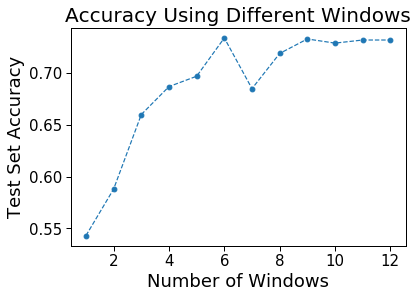

In [7]:
acc = []

for w in range(1, 13):
    acc = np.hstack([acc, show_plot('H', w)])
    
plt.plot(range(1, 13), acc, linestyle='--', marker='o')
plt.title('Accuracy Using Different Windows')
plt.xlabel('Number of Windows')
plt.ylabel('Test Set Accuracy')